Автор: Лейман М.А.   
Дата создания: 28.04.2025  

# Задание ZALA  
## 4. Детектирование множества объектов
### ___Модель___: __MobileNet GridNet__   
#### ___Backbone___: MobileNet  
#### ___Детекция___: на выходе последнего слоя детекция  

Предсказывает ячейки в которых есть объекты

#### Многоклассовая детекция

Датасеты: DOTA, UAVOD, VEDAI



## Импорты

In [16]:
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import torch
from matplotlib import rcParams
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = (14,6)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import random
from torch.utils.data import random_split
from PIL import ImageOps
from tqdm import tqdm


print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)

Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/devsTraining/zala_task


## Проверка GPU

In [17]:
# Устанавливаем device:  gpu или cpu


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.6.0+cu124
версия  cuDNN:           90100
Fri Jun  6 19:09:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
| 30%   53C    P2             89W /  170W |   10655MiB /  12288MiB |     54%      Default |
|                                         

In [18]:
# Получаем текущую директорию
path_dir = os.getcwd()
print("Текущая директория:", path_dir)

DATA_DIR = os.path.abspath(os.path.join(path_dir, 'dataset'))
print("Путь к dataset:", DATA_DIR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Текущая директория: /home/maksim/develops/python/devsTraining/zala_task
Путь к dataset: /home/maksim/develops/python/devsTraining/zala_task/dataset


## ДАТАСЕТ

In [19]:
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class YOLOHeatmapDataset(Dataset):
    """
    Dataset для anchor-based multi-label классификации ячеек по YOLO-аннотациям.
    Каждой ячейке может быть присвоено до B классов (по якорям).

    Возвращает:
        img: Tensor [3, H, W]
        target: Tensor [B*C, S, S]
    """

    def __init__(self, images_dir, labels_dir, image_size=736, grid_size=30, num_classes=8, num_anchors=3, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(images_dir, '*.jpg')))
        self.label_paths = sorted(glob.glob(os.path.join(labels_dir, '*.txt')))
        self.image_size = image_size
        self.grid_size = grid_size
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.transform = transform or transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = self.transform(img)

        target = torch.zeros((self.num_anchors, self.num_classes, self.grid_size, self.grid_size))

        with open(self.label_paths[idx], 'r') as f:
            for line in f:
                cls, cx, cy, w, h = map(float, line.strip().split())
                cls = int(cls)

                gx = int(cx * self.grid_size)
                gy = int(cy * self.grid_size)

                # добавляем метку в свободный anchor (или в последний)
                placed = False
                for anchor in range(self.num_anchors):
                    if target[anchor, cls, gy, gx] == 0:
                        target[anchor, cls, gy, gx] = 1
                        placed = True
                        break
                if not placed:
                    target[-1, cls, gy, gx] = 1

        # выход  [B*C, S, S]
        target = target.view(self.num_anchors * self.num_classes, self.grid_size, self.grid_size)

        return img, target


## МОДЕЛЬ

In [20]:
import torch
import torch.nn as nn
from torchvision import models

class YOLOCellClassifier(nn.Module):
    """
    Модель на базе MobileNetV2 для предсказания anchor-based heatmap.
    
    Параметры:
        num_classes (int): Количество классов объектов (C).
        num_anchors (int): Количество якорей на ячейку (B).
        grid_size (int): Размер сетки по одной стороне (S).
    Упрощённая anchor-based модель: предсказывает, есть ли объект каждого класса
    в каждой ячейке (до B объектов).

    """
    def __init__(self, num_classes=8, num_anchors=3, grid_size=30):
        super(YOLOCellClassifier, self).__init__()
        self.C = num_classes
        self.B = num_anchors
        self.S = grid_size

        mobilenet = models.mobilenet_v2(weights=None)
        self.backbone = mobilenet.features  # [B, 1280, H/32, W/32]

        out_channels = self.B * self.C  # только вероятности классов

        self.head = nn.Sequential(
            nn.Conv2d(1280, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, out_channels, kernel_size=1),
            nn.Upsample(size=(self.S, self.S), mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x  # [bath_size, B*C, S, S]


## LOSS 

In [21]:
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn



import torch
import torch.nn as nn
import torch.nn.functional as F

class YOLOSimplifiedLoss(nn.Module):
    def __init__(self, S, B, C, lambda_obj=1.0, lambda_noobj=0.2, lambda_cls=1.0):
        """
        S — размер сетки
        B — количество якорей на ячейку
        C — количество классов
        """
        super(YOLOSimplifiedLoss, self).__init__()
        self.S = S
        self.B = B
        self.C = C

        self.lambda_obj = lambda_obj
        self.lambda_noobj = lambda_noobj
        self.lambda_cls = lambda_cls

        self.bce = nn.BCEWithLogitsLoss(reduction='sum')  # для objectness и классов

    def forward(self, predictions, targets):
        """
        predictions: [bath, B*C, S, S] — логиты
        targets:     [bath, B*C, S, S] — бинарные метки (0 или 1)
        """
        batch_size = predictions.size(0)

        # [bath, B, C, S, S]
        preds = predictions.view(batch_size, self.B, self.C, self.S, self.S)
        targs = targets.view(batch_size, self.B, self.C, self.S, self.S)

        # Objectness mask (есть ли объект в позиции)
        obj_mask = targs > 0.5  # [bath, B, C, S, S]
        noobj_mask = ~obj_mask

        # Objectness loss
        obj_loss = self.bce(preds[obj_mask], targs[obj_mask])
        noobj_loss = self.bce(preds[noobj_mask], targs[noobj_mask])

        total_loss = self.lambda_obj * obj_loss + self.lambda_noobj * noobj_loss
        total_loss = total_loss / batch_size

        return total_loss




## Метрика

In [22]:
def calculate_precision_recall(preds, targets, num_anchors=3, num_classes=8, threshold=0.5):
    """
    Вычисляет precision и recall по каждому классу для anchor-based multi-label классификации ячеек.

    Аргументы:
        preds:   [batch_size, B*C, S, S] — логиты
        targets: [batch_size, B*C, S, S] — бинарные метки
        threshold: float — порог для перевода логитов в бинарные предсказания

    Возвращает:
        precisions: list[float], по num_classes
        recalls:    list[float], по num_classes
    """
    B, BC, S, _ = preds.shape
    assert BC == num_anchors * num_classes, f"Ожидалось B*C каналов, но получили {BC}"

    preds = preds.view(B, num_anchors, num_classes, S, S)
    targets = targets.view(B, num_anchors, num_classes, S, S)

    # сигмоида + бинаризация
    pred_mask = torch.sigmoid(preds) > threshold
    target_mask = targets.bool()

    # агрегируем по якорям — если хотя бы один якорь предсказал класс в ячейке
    pred_per_cell = pred_mask.any(dim=1)     # [B, C, S, S]
    target_per_cell = target_mask.any(dim=1) # [B, C, S, S]

    precisions, recalls = [], []

    for c in range(num_classes):
        pred_flat = pred_per_cell[:, c].flatten()
        true_flat = target_per_cell[:, c].flatten()

        TP = (pred_flat & true_flat).sum().item()
        FP = (pred_flat & ~true_flat).sum().item()
        FN = (~pred_flat & true_flat).sum().item()

        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)

        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls


## Загрузка датасета

In [23]:
from torch.utils.data import DataLoader
from torchvision import transforms

image_size=736
grid_size=30
num_classes=8
num_anchors=3

# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

path_dataset = os.path.join(current_directory, "dataset/dataset_full_3")

images_dir="images/train/"
targets_dir="labels/train/"
path_image = os.path.join(path_dataset, images_dir)
path_label = os.path.join(path_dataset, targets_dir)

from torch.utils.data import DataLoader


# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

path_dataset = os.path.join(current_directory, "dataset/dataset_full_1")

# Датасет  train
images_dir="images/train/"
targets_dir="labels/train/"
path_image = os.path.join(path_dataset, images_dir)
path_label = os.path.join(path_dataset, targets_dir)

dataset_train_1 = YOLOHeatmapDataset(
    images_dir=path_image,
    labels_dir=path_label,
    image_size=736,
    grid_size=grid_size,
    num_classes=num_classes,
    num_anchors=num_anchors
)

# Датасет  test
images_dir="images/test/"
targets_dir="labels/test/"
path_image = os.path.join(path_dataset, images_dir)
path_label = os.path.join(path_dataset, targets_dir)

dataset_test = YOLOHeatmapDataset(
    images_dir=path_image,
    labels_dir=path_label,
    image_size=736,
    grid_size=grid_size,
    num_classes=num_classes,
    num_anchors=num_anchors
)


# Датасет  val
images_dir="images/val/"
targets_dir="labels/val/"
path_image = os.path.join(path_dataset, images_dir)
path_label = os.path.join(path_dataset, targets_dir)

dataset_val = YOLOHeatmapDataset(
    images_dir=path_image,
    labels_dir=path_label,
    image_size=736,
    grid_size=grid_size,
    num_classes=num_classes,
    num_anchors=num_anchors
)



path_dataset = os.path.join(current_directory, "dataset/dataset_full_2")

# Датасет  train
images_dir="images/train/"
targets_dir="labels/train/"
path_image = os.path.join(path_dataset, images_dir)
path_label = os.path.join(path_dataset, targets_dir)

dataset_train_2 = YOLOHeatmapDataset(
    images_dir=path_image,
    labels_dir=path_label,
    image_size=736,
    grid_size=grid_size,
    num_classes=num_classes,
    num_anchors=num_anchors
)


path_dataset = os.path.join(current_directory, "dataset/dataset_1")

# Датасет  train
images_dir="images/train/"
targets_dir="labels/train/"
path_image = os.path.join(path_dataset, images_dir)
path_label = os.path.join(path_dataset, targets_dir)


dataset_train_3 = YOLOHeatmapDataset(
    images_dir=path_image,
    labels_dir=path_label,
    image_size=736,
    grid_size=grid_size,
    num_classes=num_classes,
    num_anchors=num_anchors
)

path_dataset = os.path.join(current_directory, "dataset/dataset_full_4")
images_dir="images/train/"
targets_dir="labels/train/"
path_image = os.path.join(path_dataset, images_dir)
path_label = os.path.join(path_dataset, targets_dir)

dataset_train_4 = YOLOHeatmapDataset(
    images_dir=path_image,
    labels_dir=path_label,
    image_size=736,
    grid_size=grid_size,
    num_classes=num_classes,
    num_anchors=num_anchors
)




batch_size = 12

train_loader_1 = DataLoader(dataset_train_1, batch_size=batch_size, shuffle=True)
train_loader_2 = DataLoader(dataset_train_2, batch_size=batch_size, shuffle=True)


print("Длина dataset_train_3:", len(dataset_train_3))

train_loader_3 = DataLoader(dataset_train_3, batch_size=batch_size, shuffle=True)
train_loader_4 = DataLoader(dataset_train_4, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)






Длина dataset_train_3: 1207


## Визуализация 

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

def visualize_sample(image, target, threshold=0.5, class_names=None, num_anchors=3, num_classes=8):
    """
    Визуализация предсказаний или разметки heatmap'а формата [B*C, S, S].
    
    image: Tensor [3, H, W]
    target: Tensor [B*C, S, S]
    """
    image = image.permute(1, 2, 0).cpu().numpy()
    H, W = image.shape[:2]
    
    BxC, S, _ = target.shape
    assert BxC == num_anchors * num_classes, "target shape must be [B*C, S, S]"

    # Восстановим форму [B, C, S, S]
    target = target.view(num_anchors, num_classes, S, S)

    grid_y = np.linspace(0, H, S + 1, dtype=int)
    grid_x = np.linspace(0, W, S + 1, dtype=int)

    class_cells = []
    for gy in range(S):
        for gx in range(S):
            for a in range(num_anchors):
                for c in range(num_classes):
                    if target[a, c, gy, gx] > threshold:
                        x1 = grid_x[gx]
                        y1 = grid_y[gy]
                        x2 = grid_x[gx + 1]
                        y2 = grid_y[gy + 1]
                        class_cells.append((c, gy, gx, x1, y1, x2 - x1, y2 - y1))

    # 1) Первая фигура: изображение с сеткой и ячейками 
    fig_img, ax_img = plt.subplots(figsize=(12, 12))
    ax_img.imshow(image)
    ax_img.set_title('Изображение с ячейками')

    for x in grid_x:
        ax_img.axvline(x=x, color='white', linestyle='--', linewidth=0.5)
    for y in grid_y:
        ax_img.axhline(y=y, color='white', linestyle='--', linewidth=0.5)

    for c, gy, gx, x1, y1, w, h in class_cells:
        ax_img.add_patch(patches.Rectangle((x1, y1), w, h, edgecolor='lime', linewidth=1, fill=False))
        ax_img.text(x1 + 2, y1 + 12, f"{c if class_names is None else class_names[c]}", color='red', fontsize=7)

    plt.tight_layout()
    plt.show()


        # 2) Вторая фигура: список объектов и ячеек 
    fig_text, ax_text = plt.subplots(figsize=(6, max(3, len(class_cells) * 0.25)))
    ax_text.axis('off')
    ax_text.set_title('Обнаруженные классы и ячейки', fontsize=12, pad=10)

    for idx, (c, gy, gx, *_ ) in enumerate(class_cells):
        name = class_names[c] if class_names else f"Класс {c}"
        ax_text.text(0.01, 1 - idx * 0.05, f"{name} -> Ячейка (Y={gy}, X={gx})",
                     fontsize=10, verticalalignment='top', transform=ax_text.transAxes)


    plt.tight_layout()
    plt.show()


B*C, S, S torch.Size([24, 30, 30])


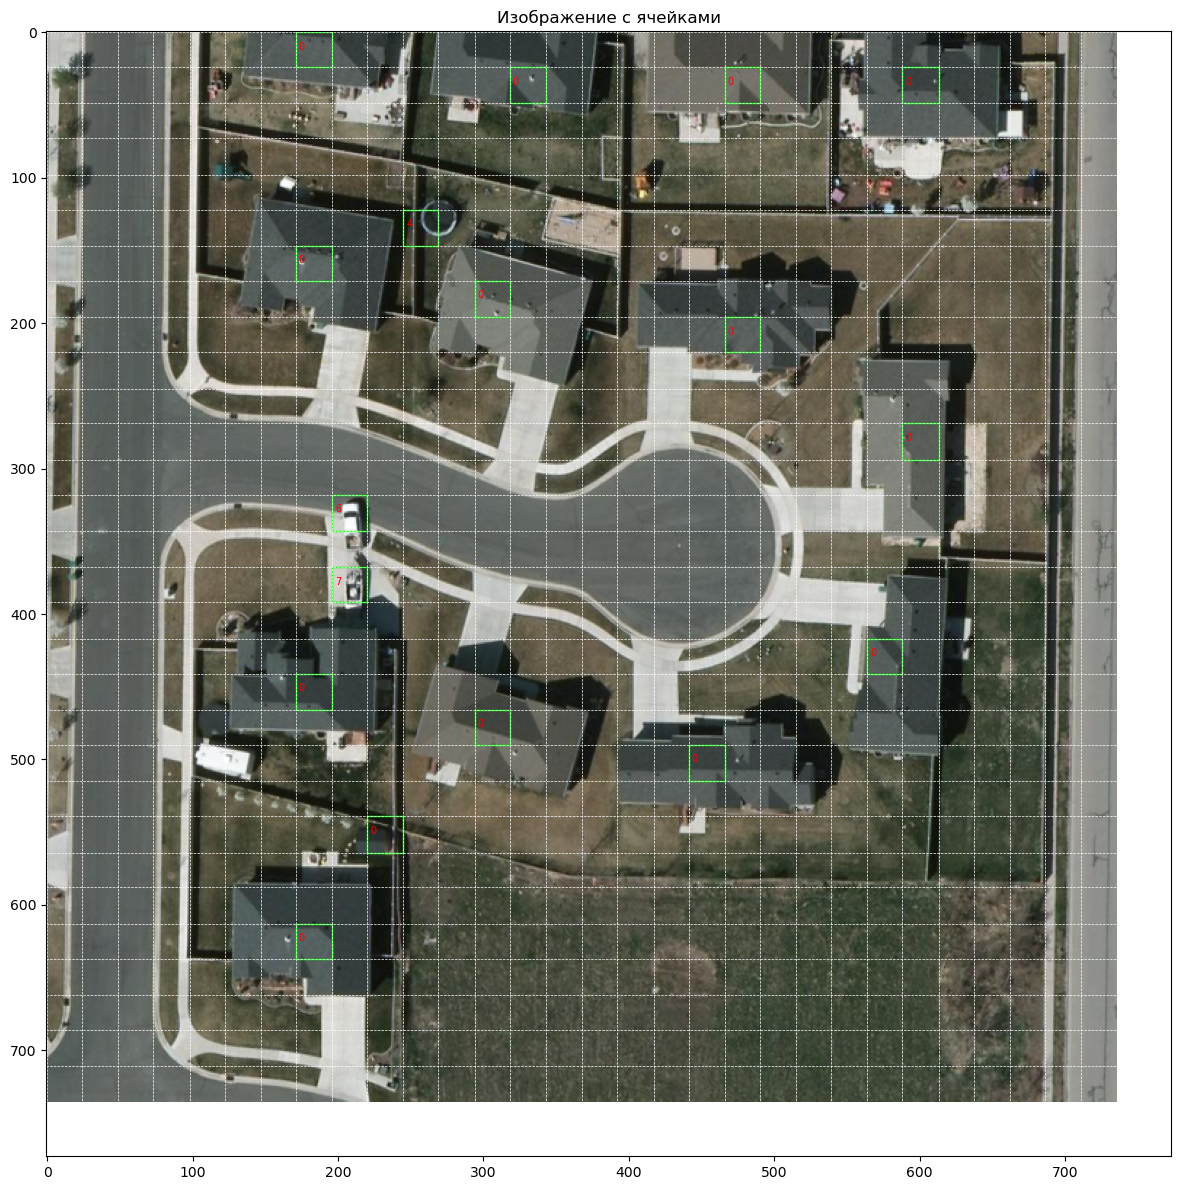

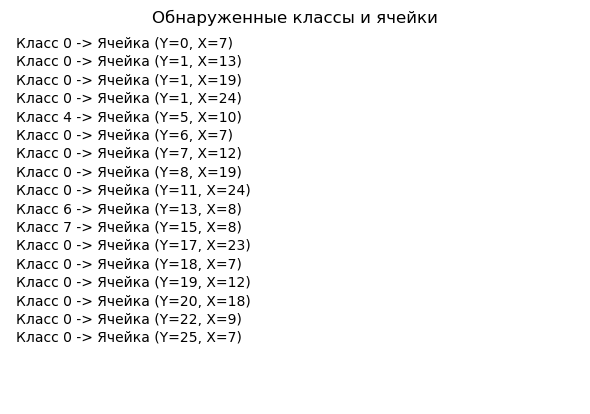

In [25]:
for images, targets in train_loader_3:
    img = images[0]
    target = targets[0]
    # target = target.permute(2, 3, 0, 1)
    print("B*C, S, S", target.shape)
    visualize_sample(img, target)
    break  # Только один раз


## Функция тренировки

In [26]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_prec'], label='Train Precision')
    plt.plot(epochs, history['val_prec'], label='Val Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_recall'], label='Train Recall')
    plt.plot(epochs, history['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()



def train_model(model, train_loader, val_loader, optimizer, scheduler, loss_fn, metric_fn,
                num_epochs=1, device='cuda', save_path='best_model.pth'):

    model = model.to(device)
    history = {
        'train_loss': [], 'val_loss': [],
        'train_prec': [], 'val_prec': [],
        'train_recall': [], 'val_recall': []
    }

    best_val_recall = 0.0  # для отслеживания лучшего recall

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_prec, train_recall = 0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        for images, targets in loop:
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)

    
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            prec, recall = metric_fn(outputs.detach(), targets)

            train_loss += loss.item()

            avg_prec = sum(prec) / len(prec)
            avg_recall = sum(recall) / len(recall)

            train_prec += avg_prec
            train_recall += avg_recall


            loop.set_postfix(loss=loss.item(), prec=prec, recall=recall)

        n_train = len(train_loader)
        history['train_loss'].append(train_loss / n_train)
        history['train_prec'].append(train_prec / n_train)
        history['train_recall'].append(train_recall / n_train)

        # Валидация
        model.eval()
        val_loss, val_prec, val_recall = 0, 0, 0

        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Validation [{epoch+1}/{num_epochs}]", leave=False)
            for images, targets in val_loop:

                images = images.to(device)
                targets = targets.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, targets)
                prec, recall = metric_fn(outputs, targets)

                val_loss += loss.item()

                avg_prec = sum(prec) / len(prec)
                avg_recall = sum(recall) / len(recall)

                val_prec += avg_prec
                val_recall += avg_recall

                val_loop.set_postfix(loss=loss.item(), prec=prec, recall=recall)

        n_val = len(val_loader)
        history['val_loss'].append(val_loss / n_val)
        history['val_prec'].append(val_prec / n_val)
        history['val_recall'].append(val_recall / n_val)

        print(f"\n Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {history['train_loss'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f} | "
              f"Val Prec: {history['val_prec'][-1]:.4f} | Val Recall: {history['val_recall'][-1]:.4f}\n")
        recall_avg = val_recall / n_val
        # Сохраняем лучшую модель по recall
        if recall_avg > best_val_recall:
            best_val_recall = recall_avg
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model at epoch {epoch+1} with val recall {best_val_recall:.4f}")

        scheduler.step()

    plot_metrics(history)
    return history


## Обучение

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import gc
gc.collect()
torch.cuda.empty_cache()


save_path="models_custom/checkpoints"
name_model = "ancorMobileNet_model_1.pth"

model_path = os.path.join(save_path, name_model)



model = YOLOCellClassifier(num_classes=8)

# model.load_state_dict(torch.load(model_path))


#  Оптимайзер
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.001,  # добавляем регуляризацию
    amsgrad=False
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)



# Функция потерь 
loss_fn = YOLOSimplifiedLoss(S=30, B=3, C=8)



metric_fn = calculate_precision_recall


# history = train_model(
#     model,
#     train_loader_3,
#     val_loader,
#     optimizer,
#     scheduler,
#     loss_fn=loss_fn,
#     metric_fn=metric_fn,
#     num_epochs=10,
#     device='cuda',
#     save_path=model_path
# )


## Использование модели

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

def visualize_model_predictions(image_tensor, outputs, threshold=0.5, num_anchors=3, num_classes=8, class_names=None, max_entries=100):
    """
    Визуализация предсказаний YOLOHeatmap: ячейки с вероятностями.
    Формат выхода: [1, A*C, S, S]
    """
    assert image_tensor.ndim == 3, "Ожидается тензор изображения [3, H, W]"
    assert outputs.ndim == 4 and outputs.shape[0] == 1, "Ожидается выход модели [1, A*C, S, S]"

    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    H, W = image.shape[:2]
    _, AC, S, _ = outputs.shape

    A = num_anchors
    C = num_classes

    assert AC == A * C, f"Размер выхода {AC} не равен {A}*{C}"

    heatmap = outputs.view(A, C, S, S)

    grid_y = np.linspace(0, H, S + 1, dtype=int)
    grid_x = np.linspace(0, W, S + 1, dtype=int)

    class_cells = []
    for gy in range(S):
        for gx in range(S):
            for a in range(A):
                for c in range(C):
                    score = torch.sigmoid(heatmap[a, c, gy, gx]).item()
                    if score > threshold:
                        x1 = grid_x[gx]
                        y1 = grid_y[gy]
                        x2 = grid_x[gx + 1]
                        y2 = grid_y[gy + 1]
                        class_cells.append((c, gy, gx, score, x1, y1, x2 - x1, y2 - y1))

    # Обрезаем, если слишком много
    class_cells = sorted(class_cells, key=lambda x: -x[3])[:max_entries]

    # 1: Визуализация ячеек 
    fig_img, ax_img = plt.subplots(figsize=(8, 8))
    ax_img.imshow(image)
    ax_img.set_title('Обнаруженные ячейки')

    for x in grid_x:
        ax_img.axvline(x=x, color='white', linestyle='--', linewidth=0.5)
    for y in grid_y:
        ax_img.axhline(y=y, color='white', linestyle='--', linewidth=0.5)

    for c, gy, gx, score, x1, y1, w, h in class_cells:
        ax_img.add_patch(patches.Rectangle((x1, y1), w, h, edgecolor='lime', linewidth=1, fill=False))
        label = class_names[c] if class_names else f"{c}"
        ax_img.text(x1 + 2, y1 + 12, f"{label} ({score:.2f})", color='yellow', fontsize=7)

    plt.tight_layout()
    plt.show()

    # 2: Текстовая таблица с вероятностями 
    line_height = 0.035  # Чем меньше — тем плотнее
    fig_height = max(1.5, line_height * len(class_cells) + 0.)

    fig_text, ax_text = plt.subplots(figsize=(6, fig_height))
    ax_text.axis('off')
    ax_text.set_title('Классы, вероятности и ячейки')

    for idx, (c, gy, gx, score, *_ ) in enumerate(class_cells):
        name = class_names[c] if class_names else f"Класс {c}"
        ax_text.text(
            0.01, 1 - idx * line_height,
            f"{name:<12} -> Ячейка (Y={gy:02}, X={gx:02}) — Score: {score:.2f}",
            fontsize=9,
            transform=ax_text.transAxes
        )

    plt.tight_layout()
    plt.show()


In [34]:
import torch
from PIL import Image
from torchvision import transforms


# Путь к изображению
img_path = "/home/maksim/develops/python/devsTraining/zala_task/dataset/TEST/images/P0179_0_crop8.jpg"
img_path = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_1/images/test/00000001_1_crop0.jpg"


save_path="models_custom/checkpoints"
name_model = "ancorMobileNet_model_1.pth"

model_path = os.path.join(save_path, name_model)


# 1. Создаём модель
model = YOLOCellClassifier(num_classes=8)

# 2. Загружаем сохранённые веса
# model.load_state_dict(torch.load(model_path, map_location='cpu'))  # или 'cuda' если GPU доступен

# 3. Переводим модель в eval режим
model.eval()

# 4. на CPU или GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 5. Загрузка изображения
image = Image.open(img_path).convert('RGB')

# 6. Преобразования (пример, адаптируй под свои, если нужно)
transform = transforms.Compose([
    transforms.Resize((736, 736)),                  # размер, на котором училась модель
    transforms.ToTensor(),                          # перевод в тензор [0,1], формат [C,H,W]
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  
    #                      std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image)  # [C, H, W]

# 7. Добавляем batch dimension
input_batch = input_tensor.unsqueeze(0)  # [1, C, H, W]

# 8. Переносим на устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_batch = input_batch.to(device)
model.to(device)

# Предсказания:
model.eval()
with torch.no_grad():
    image_tensor = transforms.ToTensor()(image)  
    input_tensor = image_tensor.unsqueeze(0).to(device)
    outputs = model(input_tensor)






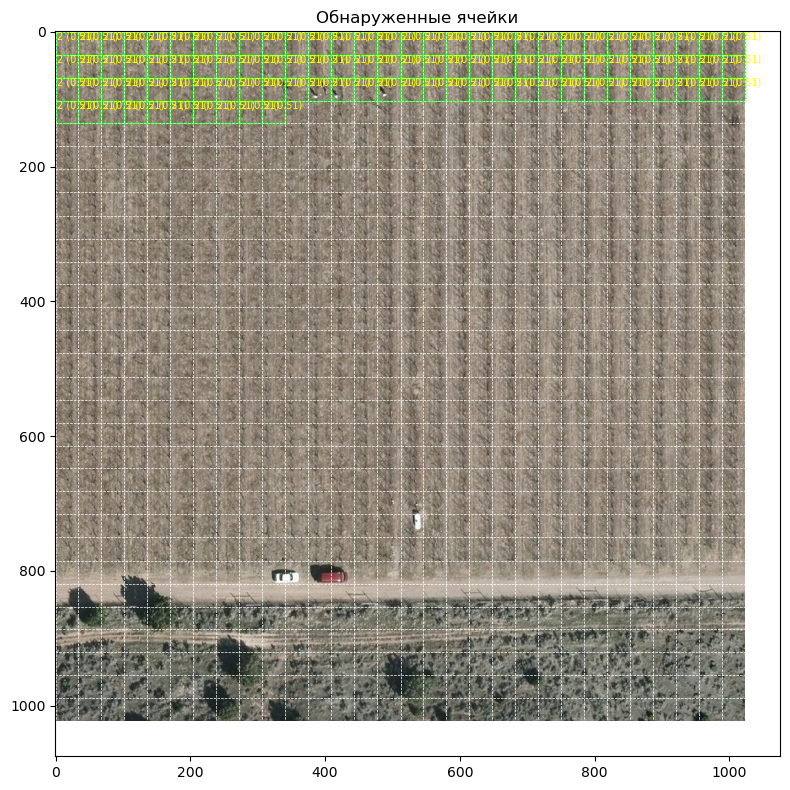

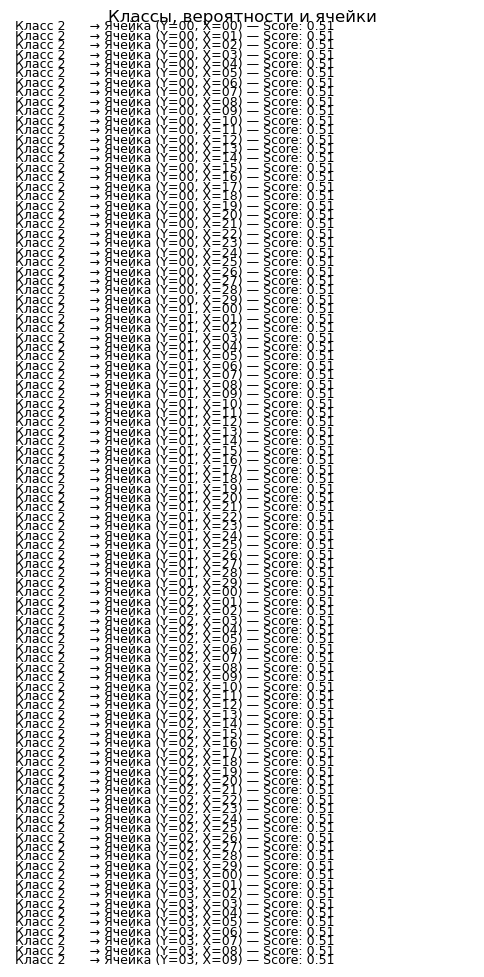

In [35]:
# Названия классов:
class_names = ['House', 'Plane', 'mesh', 'harbor', 'well', 'helicopter', 'vehicle', 'ship']

# Визуализация:
visualize_model_predictions(image_tensor, outputs, threshold=0.5,
                            num_anchors=3, num_classes=8,
                            class_names=None)


## Сравнение

## ПАРАМЕТРЫ МОДЕЛИ

In [66]:
from ptflops import get_model_complexity_info




with torch.cuda.device(0):  
    macs, params = get_model_complexity_info(model, (3, 512, 512), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
    print(f'FLOPs: {macs}')
    print(f'Parameters: {params}')


FLOPs: 3.18 GMac
Parameters: 8.14 M


In [67]:
import torch.nn as nn



layer_count = sum(1 for layer in model.modules() if isinstance(layer, (nn.Conv2d, nn.BatchNorm2d, nn.ReLU, nn.ReLU6, nn.LeakyReLU,  nn.Dropout)))
print(f"Количество слоёв: {layer_count}")





layer_count = sum(1 for _ in model.modules())
print(f"Всего слоёв: {layer_count}")


Количество слоёв: 143
Всего слоёв: 216


In [68]:
from torchinfo import summary



summary(model, input_size=(1, 3, 736, 736))


Layer (type:depth-idx)                             Output Shape              Param #
YOLOCellClassifier                                 [1, 24, 30, 30]           --
├─Sequential: 1-1                                  [1, 1280, 23, 23]         --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 368, 368]         --
│    │    └─Conv2d: 3-1                            [1, 32, 368, 368]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 368, 368]         64
│    │    └─ReLU6: 3-3                             [1, 32, 368, 368]         --
│    └─InvertedResidual: 2-2                       [1, 16, 368, 368]         --
│    │    └─Sequential: 3-4                        [1, 16, 368, 368]         896
│    └─InvertedResidual: 2-3                       [1, 24, 184, 184]         --
│    │    └─Sequential: 3-5                        [1, 24, 184, 184]         5,136
│    └─InvertedResidual: 2-4                       [1, 24, 184, 184]         --
│    │    └─Sequential: 3-6   